## CSCI 470 Activities and Case Studies

1. For all activities, you are allowed to collaborate with a partner. 
1. For case studies, you should work individually and are **not** allowed to collaborate.

By filling out this notebook and submitting it, you acknowledge that you are aware of the above policies and are agreeing to comply with them.

Some considerations with regard to how these notebooks will be graded:

1. Cells in which "# YOUR CODE HERE" is found are the cells where your graded code should be written.
2. In order to test out or debug your code you may also create notebook cells or edit existing notebook cells other than "# YOUR CODE HERE". We actually highly recommend you do so to gain a better understanding of what is happening. However, during grading, **these changes are ignored**. 
2. You must ensure that all your code for the particular task is available in the cells that say "# YOUR CODE HERE"
3. Every cell that says "# YOUR CODE HERE" is followed by a "raise NotImplementedError". You need to remove that line. During grading, if an error occurs then you will not receive points for your work in that section.
4. If your code passes the "assert" statements, then no output will result. If your code fails the "assert" statements, you will get an "AssertionError". Getting an assertion error means you will not receive points for that particular task.
5. If you edit the "assert" statements to make your code pass, they will still fail when they are graded since the "assert" statements will revert to the original. Make sure you don't edit the assert statements.
6. We may sometimes have "hidden" tests for grading. This means that passing the visible "assert" statements is not sufficient. The "assert" statements are there as a guide but you need to make sure you understand what you're required to do and ensure that you are doing it correctly. Passing the visible tests is necessary but not sufficient to get the grade for that cell.
7. When you are asked to define a function, make sure you **don't** use any variables outside of the parameters passed to the function. You can think of the parameters being passed to the function as a hint. Make sure you're using all of those variables.
8. Finally, **make sure you run "Kernel > Restart and Run All"** and pass all the asserts before submitting. If you don't restart the kernel, there may be some code that you ran and deleted that is still being used and that was why your asserts were passing.

# Supervised Learning

Yeah, you're reading that right. In this activity, we're finally doing some real machine learning!

We're going to:
1. Create a $k$NN classification machine learning model using scikit-learn
2. Train our model with some synthetic data
3. Use our model to make predictions about parts of our synthetic data that it hasn't seen before
4. Use those predictions to evaluate our model's performance by comparing its predictions with the unseen data's actual labels

## scikit-learn API

Models in scikit-learn are called _Estimators_ and the steps to use them are:

1. Initialize the model by setting its parameters `model = Model(param_1=val, param_2=val)`
1. Fit the model `model.fit(features, labels)`
1. Predict labels with the fit model `model.predict(features)`


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn as sk

%matplotlib inline
plt.style.use("ggplot")

In [2]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

Let's start by making some synthetic data that we can use to train our model.

In the real world, collecting information from an entire population is far too expensive so datasets are built by collecting (hopefully relevant) information about randomly chosen samples of the population. 

The entire goal of machine learning and statistics is to use these datasets to form understandings of entire populations (without ever actually interacting with the entire population).

In [3]:
# Imagine we have a very large population
pop_X, pop_y = make_blobs(n_samples=10000, random_state=0)

# We will now collect 10000 random samples from this population
X, y = pop_X[:1000], pop_y[:1000]

Now we're going to split all our sample data into train and test sets. We do so using sklearn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

This is a very important step when creating machine learning models. In order to fairly evaluate a model's performance, we want to feed it data that neither us or it have ever seen before. Ideally, this allows us to analyze the true strength of our model's estimations on completely new, unseen data from our population.

Also notice how we set the `random_state` to `42`. Any number will do so we may as well choose [the answer to life, the universe and everything](https://en.wikipedia.org/wiki/42_(number)#The_Hitchhiker's_Guide_to_the_Galaxy). This ensures that every time we run our program, we get the same splits. This prevents us or our model from ever being exposed to testing data (which would corrupt our testing data's ability to analyze the true strength of our model).

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

print(f"All Data:        {len(X)} points")
print(f"Training data:   {len(X_train)} points")
print(f"Testing data:    {len(X_test)} points")

All Data:        1000 points
Training data:   800 points
Testing data:    200 points


Whenever a dataset evaluates the performance of two+ models and a model is chosen based off the results, that dataset's ability to predict how well the model will perform on completely new, unseen data from a population is corrupted. It is corrupted because the chosen model is almost certainly at least slightly overfit to the dataset used to evaluate performance. 

Therefore, a test set should only ever be used to see if a model should be deployed to the real world. Ideally, it only gets executed a single time. Using it more than ~three times makes it highly likely the finalized model is going to be at least somewhat overfit to your test set.

During [Kaggle competitions](https://www.kaggle.com/competitions), the test set labels are never released to competitors and, while a competition is going, competitors are only allowed to see how their model performs compared to everyone else on a random subset of the test set. At the very end of the competition, everyone's actual rankings are calculated based off how their models perform on the full, never before seen, test set.

Hopefully you can see that it is very, very, very important we as model creators know as little as possible about 
the test set so that we can avoid acidentally overfitting our model to it.

Given this reality, creating multiple evaluation sets is oftentimes necessary so that we can choose the best configurations for our model without corrupting our test set. Again, there are many ways to split up data but for now we will use the same `train_test_split` function we used above.

*An evaluation set designed to choose the best model parameters is called the validation set*

In [5]:
X_model, X_valid, y_model, y_valid = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

print(f"New training data:   {len(X_model)} points")
print(f"Validation data:   {len(X_valid)} points")

New training data:   640 points
Validation data:   160 points


Now that we've split up our dataset, we can visualize our data. This step is called [Exploratory Data Analysis (EDA)](https://en.wikipedia.org/wiki/Exploratory_data_analysis). During EDA, we create visualizations that help us better understand the main characteristics of our dataset. 

It's very important that when we're performing EDA, we only ever look at our training dataset. Doing so will prevent us from accidentally formulating unfair understandings of our test data that lead us to create models which achieve better prediction results for our test set compared to those of uncollected samples in a population.

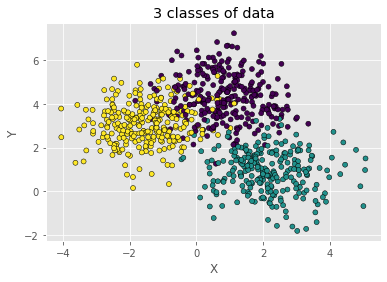

In [6]:
# Let's create a graph where we plot our data across both of its dimensions and color each point by its label
plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train, s=25, edgecolor='k')
plt.title("3 classes of data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

Our dataset is fairly simple so a single graph is all we really need for sufficient EDA.

In the real world, datasets can be much more complicated so more graphs (dot plots, box plots, bar charts, side-by-side comparisons, etc.) may be necessary. A big part of data science is determining the best visualizations to share the characteristics of a given dataset with other people.

Also, in the real world, we would now begin cleaning our data. However, for this dataset, we can skip this setp because it is already perfectly clean.

Anyways, now that we have a good idea of what our data looks like, we can start thinking about models that will make the strongest predictions. In the reading, we discussed $k$NN estimators, decision trees, and random forests. For our dataset, any of these models will work, so let's start with creating a [$k$NN classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

*If at the end of this exercise you want to go further, consider also training a decision tree and random forest model, then comparing each model's performance.*

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [8]:
# Step 0 - Define our  model's parameters
k = 5
# Step 1 - Initialize model with parameters
knn = KNeighborsClassifier(n_neighbors=k)
# Step 2 - Fit the model with data
knn.fit(X_model, y_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

Yes, it's really that simple to create a machine learning model! All we had to do was initialize a $k$NN classifier with some parameters and fit it to our data.

sklearn implements many other classification estimators that are just as easy to deploy. A list of all of the supervised estimators sklearn implements can be found [here](https://scikit-learn.org/stable/supervised_learning.html). The $k$NN (classification) model we are using is listed in section 1.6.2. Decision trees can be found in section 1.10.1 and random forests in section 1.11.2.

Now that we've created and trained a $k$nn model, we need to evaluate how good its predictions are on our validation set.

Remember, we are doing *supervised* learning. Practically, this means that we evaluate the strength of our model by:
1. Making predictions with it on evaluation data, then
2. Evaluating its predictions by comparing them with the evaluation data's actual labels

Later in the semester, we will dive into *unsupervised* learning where we won't have pre-labeled data so we'll have to come up with other ways to evaluate a model's performance.

But, for now, let's keep things simple and use some of the classification performance metrics that we discussed in class:

1. [Confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)
1. [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
1. [F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)

As you may expect, there are many more ways to evaluate a model's performance. One widely used metric not covered in this class is called [ROC AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc). Briefly, it measures a model's ability to maximize true positives at the expense of false positives. A list of all of the evaluation metrics implemented by sklearn can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html).

**Step 1**: Use our model to make predictions about test data it hasn't seen before

In [9]:
validationPredictions = knn.predict(X_valid)

**Step 2**: Evaluate our model's performance

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

In [11]:
print(confusion_matrix(y_valid, validationPredictions))

[[51  2  5]
 [ 2 45  1]
 [ 4  0 50]]


Ok, it looks like our model is making strong predictions!

As discussed in class, a confusion matrix compares our data's true labels (horizontal axis) with the labels our model predicts (vertical axis). We want a confusion matrix's diagonal values to be very large because that indicates our model's predicted labels match the data's actual labels.

This is clearly the case for our model! Awesome.

In [12]:
print(classification_report(y_valid, validationPredictions))

              precision    recall  f1-score   support

           0       0.89      0.88      0.89        58
           1       0.96      0.94      0.95        48
           2       0.89      0.93      0.91        54

    accuracy                           0.91       160
   macro avg       0.92      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



In [13]:
f1_score(y_valid, validationPredictions, average="weighted")

0.912550447264406

The classification report and weighted f-1 scores confirm our initial findings from the confusion matrix. Our model is definitely making strong predictions.

But can we do any better?

Let's figure out if changing our model's parameters would lead to even stronger results. To do this, we'll compare the weighted F-1 scores achieved by a variety of different parameter combinations.

**Ok reader, it's your turn. Take the wheel!**

Remember, we want to see if we can make our model any better by trying multiple different $k$NN parameter values

1. First, we'll train multiple models with different k values and evaluate them on the *training set* (Yes, you read that right. The training set! Use the same dataset you used to train your model when testing your model's performance.).
2. Second, we'll train multiple models with those same values of k and evaluate them on the *validation set*.
3. From these two sets of results, we can plot our scores to determine the best value of k

In [14]:
def get_knn_training_scores(ks, model_features, model_labels):
    """Determine the f1-score of k values for kNN on a given data set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the training set
    """
    # YOUR CODE HERE
    td = {}
    for key in ks:
      # Step 1 - Initialize model with parameters
      knn = KNeighborsClassifier(n_neighbors=key)
      # Step 2 - Fit the model with data
      knn.fit(model_features, model_labels)
      # Step 3 - Predictions
      validation = knn.predict(model_features)
      # Step 4 - F1 scoring (?)
      td[key] = f1_score(model_labels, validation, average='weighted')
    return td


In [15]:
ks = [1,2,3]
test_knn_train = get_knn_training_scores(ks, X_model, y_model)
assert list(test_knn_train.keys()) == ks
assert len(test_knn_train.keys()) == 3
assert np.array(list(test_knn_train.values())).all() <= 1
assert np.array(list(test_knn_train.values())).all() > 0

In [16]:
def get_knn_validation_scores(ks, model_features, model_labels, validation_features, validation_labels):
    """Train a model on a dataset then return the F-1 score on another set
    Args:
        ks (int iterable): iterable of all the k values to apply
        model_features (iterable): the features from the model set to train on
        model_labels (iterable): the labels from the model set to train on
        validation_features (iterable): the features from the validation set to test on
        validation_labels (iterable): the labels from the validation set to test on
        
    Returns:
        dictionary: key is the k value and value is the weighted f1_score on the validation set
    """
    # YOUR CODE HERE
    td = {}
    for key in ks:
      # Step 1 - Initialize model with parameters
      model = KNeighborsClassifier(n_neighbors=key)
      # Step 2 - Fit the model with data
      model.fit(model_features, model_labels)
      # Step 3 - Predictions
      ypred = model.predict(validation_features)
      # Step 4 - F1 scoring (?)
      td[key] = f1_score(validation_labels, ypred, average='weighted')
    return td


In [17]:
ks = [1,2,3]
test_knn_valid = get_knn_validation_scores(ks, X_model, y_model, X_valid, y_valid)
assert list(test_knn_train.keys()) == ks
assert len(test_knn_train.keys()) == 3
assert np.array(list(test_knn_train.values())).all() <= 1
assert np.array(list(test_knn_train.values())).all() > 0
assert test_knn_valid != test_knn_train

Now let's use these functions to determine the best value for $k$.

In [18]:
ksToTest = [1,3,5,7,10,20,50,100]
training_scores = get_knn_training_scores(ksToTest, X_model, y_model)
validation_scores = get_knn_validation_scores(ksToTest, X_model, y_model, X_valid, y_valid)

Here, we'll plot the training and validation scores that were returned from the functions. 

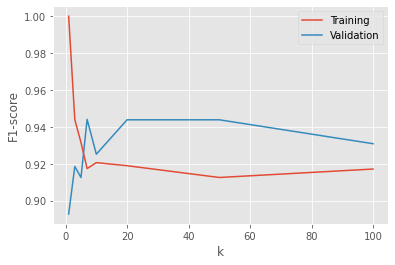

In [19]:
pd.Series(training_scores, name="Training").plot(kind="line")
pd.Series(validation_scores, name="Validation").plot(kind="line", label="Validation")

plt.legend()
plt.xlabel("k")
plt.ylabel("F1-score")
plt.show()

In [20]:
# Select the best value for k and set it to bestK
# YOUR CODE HERE
bestK = 20

In [21]:
clf = KNeighborsClassifier(bestK)
clf.fit(X_train, y_train)
testPredictions = clf.predict(X_test)

After selecting the best hyperparameter, we can see how well our model does on the test dataset. This is our final check to confirm that our model is sufficient for the real world.

This should be a strong representation of how well our model will perform on new, unseen data!

Remember, we can't make any changes to our model based off these results. If we did, the changes would corrupt our test set.

In [22]:
print("Confusion Matrix: \n")
print(confusion_matrix(y_test, testPredictions))
print("\n\nClassification Report:\n")
print(classification_report(y_test, testPredictions))

Confusion Matrix: 

[[53  2  8]
 [ 4 68  0]
 [ 1  0 64]]


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.84      0.88        63
           1       0.97      0.94      0.96        72
           2       0.89      0.98      0.93        65

    accuracy                           0.93       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200



In [23]:
assert f1_score(y_test, testPredictions, average="weighted") > 0.92

**When should the training, validation, or test set be used?**

- The test set should only be used to evaluate whether or not a model can be deployed to the real world. Model creators should undestand as little about the test set as possible. It should be used as little as possible - ideally only once.

- The validation set can be used to choose the best model hyper parameters. Comparing too many model configrations on the same validation set essentially guarantees that the model's configurations will be overfit to the validation set. To help avoid this, there are many cleverly designed ways to create a validation set and, if necessary, multiple validation sets can be created. *It is very important to consider all factors that may contribute to an overfit validation set.*

- The training set should be used to create new validation sets or to train new models

**Summary**

Eggscellent work! We just did real machine learning (and hopefully you agree that it was suprisingly easy)! 

Right now, our conception of creating machine learning models works something like this:
1. Collect sample data from a population
1. Split dataset into training and testing sets (and split training set further as needed)
1. Perform Exploratory Data Analysis (EDA)
1. Clean dataset (not necessary in this activity)
1. Choose a good model for the dataset (in this activity, we just guessed that $k$NN is best)
1. Choose good parameters for our model
1. Evaluate overall performance

In the next activity, we will expand on this conception and develop an intuitive understanding of regularization!

## Feedback

In [24]:
def feedback():
    """Provide feedback on the contents of this exercise
    
    Returns:
        string
    """
    # YOUR CODE HERE
    return("I enjoyed the assignment, and like that there are informative readings linked.")